## Importing the necessary libraries

In [1]:
# Importing libraries 
import pandas as pd, numpy as np, plotly.express as px# manipulation and numerical operations
import plotly.graph_objects as go  # DataViz
from plotly.subplots import make_subplots # DataViz
import matplotlib.pyplot as plt # DataViz
import seaborn as sns # DataViz
from sklearn.pipeline import Pipeline # Pipeline for chaining multiple data preprocessing steps
from sklearn.preprocessing import StandardScaler # Data rescaling
from sklearn.model_selection import train_test_split # Data splitting 
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, recall_score # Evaluation Metrics
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import RandomOverSampler
import shap # Machine Learning explainability librart

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
# Loading data
training_data = pd.read_csv('C://Users//nazli//OneDrive//Desktop//DATA//DATASETS//insta//train.csv') # Training dataset
testing_data = pd.read_csv('C://Users//nazli//OneDrive//Desktop//DATA//DATASETS//insta//test.csv') # Testing dataset


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Exp Data 
-Missing values per column
-Number of duplicated rows
-Data types of columns
-Number of rows and columns
-The top few rows of the dataset will be inspected 

In [2]:
# Defining a function to return relevant information on the data
def inspect(df):
    print('\n')
    print('Missing Values: ')
    print(df.isnull().sum())
    print('\n')
    print('Duplicated Values: ')    
    print(df.duplicated().sum())
    print('\n')
    print('Data Types: ')
    print(df.dtypes)
    print('\n')
    print(f'Rows: {df.shape[0]}')   
    print(f'Attributes: {df.shape[1]}')
    print('\n')
    print('Head: ')
    print('\n')
    return df.head()

In [3]:
inspect(training_data)



Missing Values: 
profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64


Duplicated Values: 
2


Data Types: 
profile pic               int64
nums/length username    float64
fullname words            int64
nums/length fullname    float64
name==username            int64
description length        int64
external URL              int64
private                   int64
#posts                    int64
#followers                int64
#follows                  int64
fake                      int64
dtype: object


Rows: 576
Attributes: 12


Head: 




,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [4]:
inspect(testing_data)



Missing Values: 
profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64


Duplicated Values: 
2


Data Types: 
profile pic               int64
nums/length username    float64
fullname words            int64
nums/length fullname    float64
name==username            int64
description length        int64
external URL              int64
private                   int64
#posts                    int64
#followers                int64
#follows                  int64
fake                      int64
dtype: object


Rows: 120
Attributes: 12


Head: 




,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


In [5]:
# Visualizing duplicated rows in the training set
training_data_duplicated = training_data[training_data.duplicated(keep=False)]
training_data_duplicated

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
196,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
197,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
491,1,0.91,1,0.0,0,0,0,0,0,75,26,1
525,1,0.91,1,0.0,0,0,0,0,0,75,26,1


In [6]:
# Removing duplicates
training_data.drop_duplicates(inplace = True)
testing_data.drop_duplicates(inplace = True)

# Printing new rows count
print('\n')
print(f'Train new rows count: {training_data.shape[0]}')
print(f'Test new rows count: {testing_data.shape[0]}')



Train new rows count: 574
Test new rows count: 118


#### Categorize features into two groups: Continuous and binary.

In [7]:
# Defining a function to categorize features
def categorize_features(df):
    # creating empty lists
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].nunique() <= 2: # if the number of unique values per feature is either equal or smaller than 2, it gets appended to the binary_features list
            binary_features.append(col)
        else:
            continuous_features.append(col) # In case it has more unique values than 2, it get appended to the continuous_feature list
    return continuous_features, binary_features

In [8]:
# Creating lists with the function
continuous_features, binary_features = categorize_features(training_data)

In [9]:
# Printing feature categorizations
print(f'Continuous features:', continuous_features)
print(f'Binary features:', binary_features)

Continuous features: ['nums/length username', 'fullname words', 'nums/length fullname', 'description length', '#posts', '#followers', '#follows']
Binary features: ['profile pic', 'name==username', 'external URL', 'private', 'fake']


In [10]:
## EXP DATA ANALYSIS

In [11]:
# Binary Features

In [ ]:
binary_features.remove('fake') # Removing target variable from the list

In [18]:
# Creating another dataframe to label real and fake accounts
legend_df = training_data.copy()
legend_df['fake'] = legend_df['fake'].replace({0: 'Real Accounts', 1: "Fake Accounts"}) 


In [19]:
# plotting barplots for each binary feature

def create_barplots(df, legend_df):
    for feature in binary_features:
        fig = px.histogram(train, x=feature, color=legend_df['fake'],
                           color_discrete_sequence=['#636EFA','#EF553B'],
                           barmode='group', template='plotly_white',labels={'color': 'Real/Fake'})
        
        fig.update_layout(title=f'{feature}?',
                          xaxis_title=feature, yaxis_title='Count', xaxis=dict(tickmode='array',
                                                                               tickvals=[0, 1],
                                                                               ticktext=['No', 'Yes']
                                                                               ),
                     height = 650)
        
        fig.show()

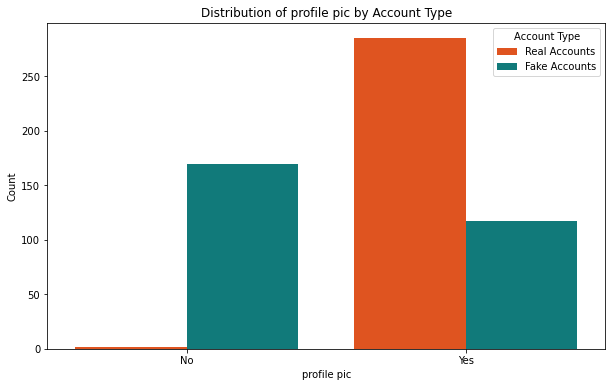

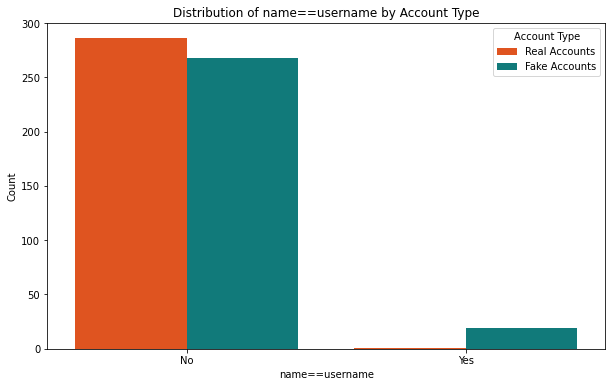

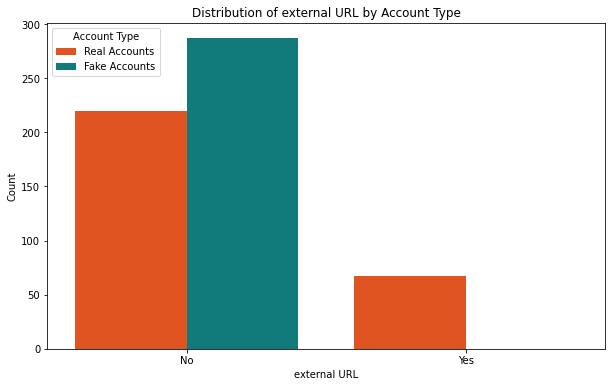

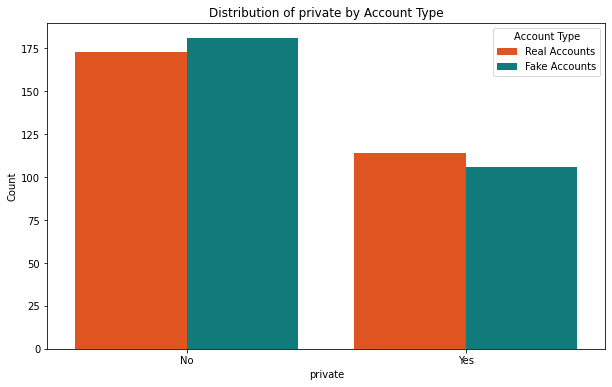

In [20]:
def crossbar(df):
    for feature in binary_features:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=feature, hue='fake', palette={0: 'orangered', 1: 'darkcyan'})
        plt.title(f'Distribution of {feature} by Account Type')
        plt.legend(title='Account Type', labels=['Real Accounts', 'Fake Accounts'])
        plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
        plt.ylabel('Count')
        plt.xlabel(feature)
        plt.show()

# Let's visualize using the function
crossbar(training_data)


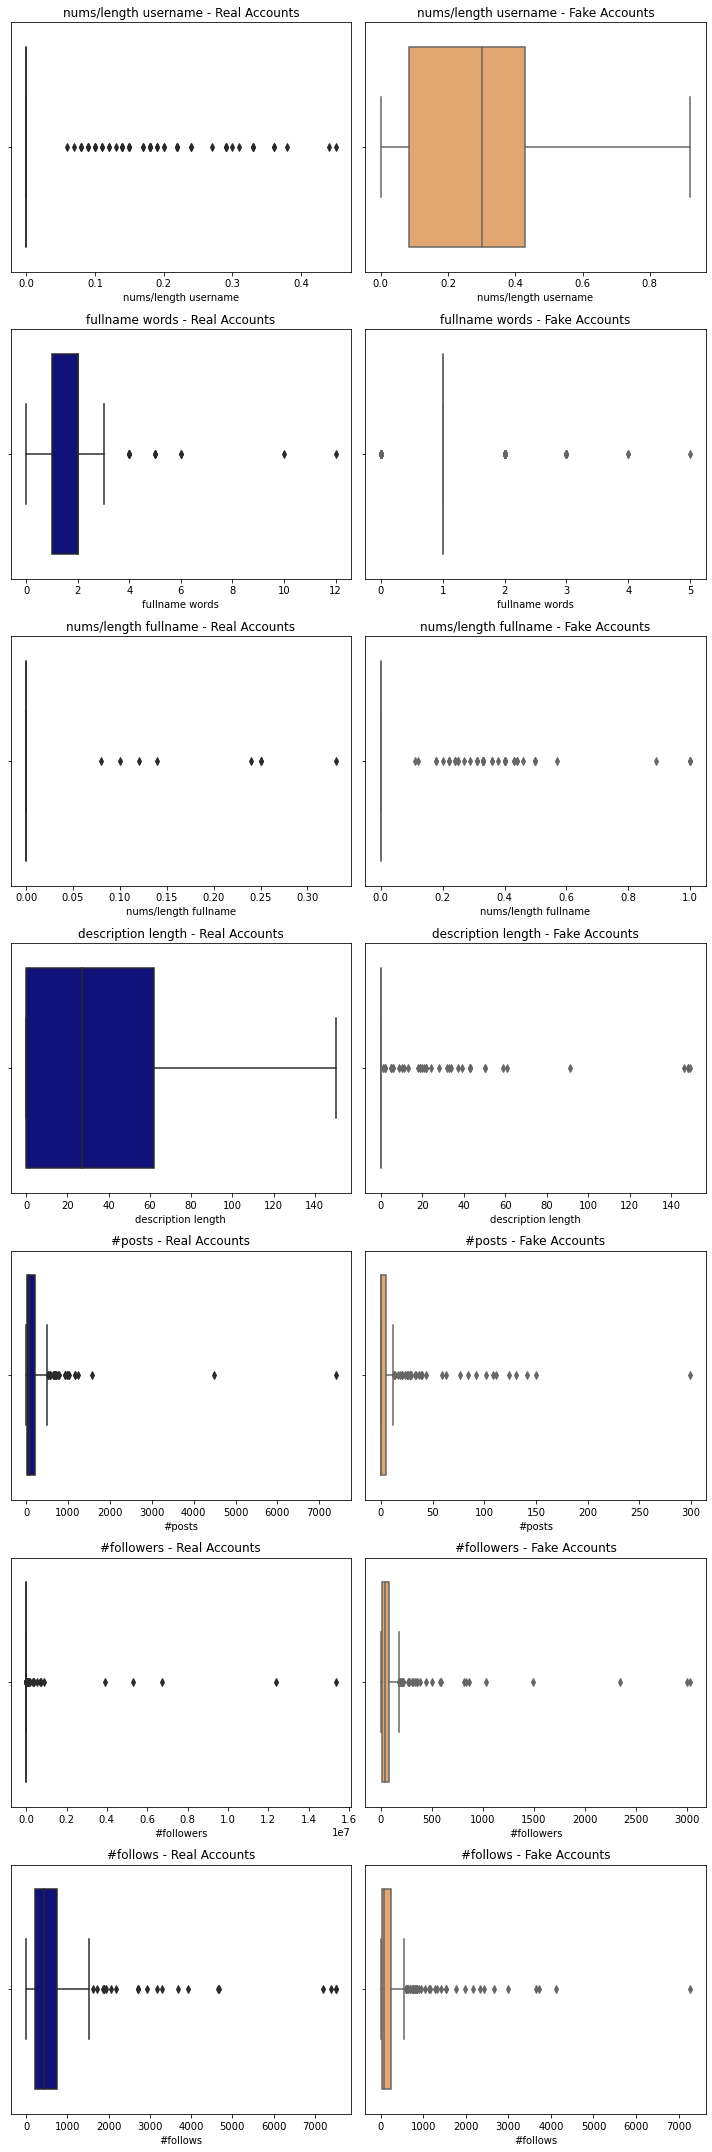

In [23]:
# Plotting Boxplots
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=2, figsize=(10, 30))

for i, col in enumerate(continuous_features):
    sns.boxplot(data=training_data[training_data['fake'] == 0], x=col, ax=axes[i, 0], color = 'darkblue')
    sns.boxplot(data=training_data[training_data['fake'] == 1], x=col, ax=axes[i, 1], color = 'sandybrown')
    axes[i, 0].set_title(col + " - Real Accounts")
    axes[i, 1].set_title(col + " - Fake Accounts")

plt.tight_layout()
plt.show()

In [24]:
fig = px.pie(legend_df, names='fake', title='Distribution of Target Variable', color_discrete_sequence = ['darkred','tomato'])
fig.update_layout(template = 'ggplot2')
fig.show()

In [26]:
# Training, predicting and evaluating baseline

# Splitting dataset into independent variables (X) and target variable (y)
X = training_data.drop('fake', axis = 1)
y = training_data['fake']

In [32]:
# Creating training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [34]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
y_prob = knn_model.predict_proba(X_val)[:, 1]

In [37]:
auc = roc_auc_score(y_val, y_prob)
print(f"AUC-ROC: {auc}")

AUC-ROC: 0.9256665768920012


In [38]:
# Initializing mode
random = RandomForestClassifier(random_state = 42)
random.fit(X_train, y_train) # Fitting to training data 

y_pred = random.predict(X_val) # Predicting on validation set


In [39]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds})

baseline_score = roc_auc_score(y_val, y_pred)
print('AUC-ROC Baseline: ', baseline_score.round(2))

AUC-ROC Baseline:  0.92


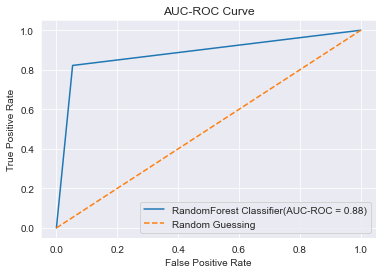



y_val value counts
0    94
1    73
Name: fake, dtype: int64


predicted value counts
(array([0, 1], dtype=int64), array([102,  65], dtype=int64))


In [85]:
sns.set_style('darkgrid')
sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f'RandomForest Classifier(AUC-ROC = {baseline_score.round(2)})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('\n')
print('y_val value counts')
print(y_val.value_counts())
print('\n')
print('predicted value counts')
print(np.unique(y_pred, return_counts=True))

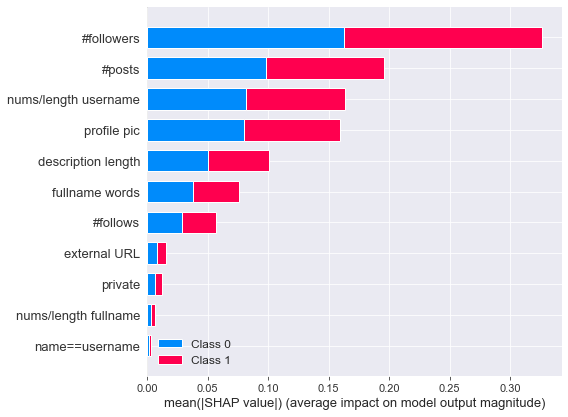

In [24]:
# Plotting Feature Importance plot
shap_values = shap.TreeExplainer(rf).shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [41]:
# create activity ratio feature
training_data['activity ratio'] = np.round(training_data['#posts'] / training_data['#followers'], 2)

# Does the account have more followers than follows?
training_data['#followers > #follows?'] = (training_data['#followers'] > training_data['#follows']).astype(int)

In [43]:
# Visualizing new features on the dataframe
training_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,activity ratio,#followers > #follows?
0,1,0.27,0,0.00,0,53,0,0,32,1000,955,0,0.03,1
1,1,0.00,2,0.00,0,44,0,0,286,2740,533,0,0.10,1
2,1,0.10,2,0.00,0,0,0,1,13,159,98,0,0.08,1
3,1,0.00,1,0.00,0,82,0,0,679,414,651,0,1.64,0
4,1,0.00,2,0.00,0,0,0,1,6,151,126,0,0.04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1,0.20,0
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1,0.67,0
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1,0.04,0
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1,0.00,0


In [45]:
fig = px.histogram(training_data, x=training_data['#followers > #follows?'], color=legend_df['fake'],
                   color_discrete_sequence=['#636EFA','#EF553B'],
                   barmode='group', template='plotly_white',labels={'color': 'Real/Fake'})
        
fig.update_layout(title='More Followers than Follows Distribution',
                  xaxis_title='#followers > #follows?', yaxis_title='Count', xaxis=dict(tickmode='array',
                  tickvals=[0, 1],
                  ticktext=['No', 'Yes']),
                  height = 800)
        
fig.show()

In [46]:
# Plotting Activity Ratio plot
fig = px.box(training_data, x='fake', y='activity ratio', color = legend_df['fake'], title = "Activity Ratio")

fig.update_layout(xaxis_title="Real/Fake", yaxis_title='Count', xaxis=dict(tickmode='array',
                                                                               tickvals=[0, 1],
                                                                               ticktext=['Real Accounts', 'Fake Accounts']
                                                                               ),
                     height = 650)

# Show the plot
fig.show()

In [47]:
training_data.isnull().sum()

profile pic                0
nums/length username       0
fullname words             0
nums/length fullname       0
name==username             0
description length         0
external URL               0
private                    0
#posts                     0
#followers                 0
#follows                   0
fake                       0
activity ratio            15
#followers > #follows?     0
dtype: int64

In [48]:
training_data.isin([np.inf, -np.inf]).sum()

profile pic               0
nums/length username      0
fullname words            0
nums/length fullname      0
name==username            0
description length        0
external URL              0
private                   0
#posts                    0
#followers                0
#follows                  0
fake                      0
activity ratio            3
#followers > #follows?    0
dtype: int64

In [50]:
# replace infinite values with NaN
training_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop rows containing NaN values
training_data.dropna(inplace=True)

In [51]:
# Measuring mean values and standard deviations
df_means = training_data.mean().round(2)
df_stds = training_data.std().round(2)
results = pd.concat([df_means, df_stds], axis = 1)
results.columns = ['Mean', 'Standard Deviation']
results

,Mean,Standard Deviation
profile pic,0.72,0.45
nums/length username,0.16,0.21
fullname words,1.47,1.06
nums/length fullname,0.04,0.13
name==username,0.03,0.18
description length,23.27,38.13
external URL,0.12,0.33
private,0.37,0.48
#posts,110.94,408.69
#followers,88366.21,926256.64


In [52]:
# Splitting Independent Features X and target variable y
X = training_data.drop('fake', axis = 1)
y = training_data.fake

In [53]:
# Spitting data into training and validation sets. 35% of data will be used for validation
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size = 0.35, random_state = 123)

XGBoost: AUC-ROC score = 0.90
[LightGBM] [Info] Number of positive: 181, number of negative: 180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501385 -> initscore=0.005540
[LightGBM] [Info] Start training from score 0.005540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

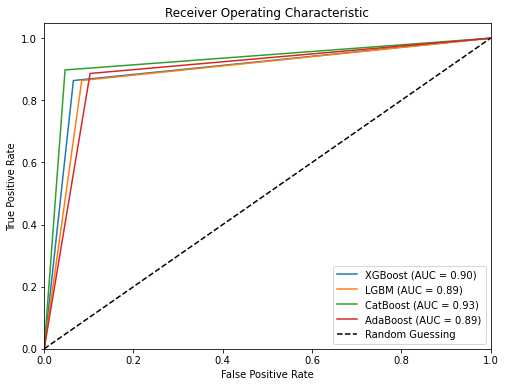

In [54]:
# Defining models
models = {
    "XGBoost": XGBClassifier(random_state = 42),
    "LGBM": LGBMClassifier(random_state = 42),
    "CatBoost": CatBoostClassifier(verbose=False, random_state = 42),
    "AdaBoost": AdaBoostClassifier(random_state = 42)
}

# Defining the pipeline process for each model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ("scaler", StandardScaler()), # Rescaling data
        ("model", model) # Initializing model
    ])

# Fitting and computing AUC-ROC scores
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    results[name] = {
        "pipeline": pipeline,
        "auc": auc
    }
    print(f"{name}: AUC-ROC score = {auc:.2f}")
    
# Plot AUC-ROC curve for all models
plt.figure(figsize=(8, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_val, result["pipeline"].predict(X_val))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
# Creating activity ratio feature
testing_data['activity ratio'] = np.round(testing_data['#posts'] / testing_data['#followers'], 2)

# Does the account has more followers than follows?
testing_data['#followers > #follows?'] = (testing_data['#followers'] > testing_data['#follows']).astype(int)

# replace infinite values with NaN
testing_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop rows containing NaN values
testing_data.dropna(inplace=True)

In [58]:
testing_data # Displaying test set

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,activity ratio,#followers > #follows?
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0,0.07,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0,0.09,1
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0,0.97,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0,0.02,1
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,1,0.11,0
116,1,0.40,1,0.00,0,0,0,0,4,150,164,1,0.03,0
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,1,0.00,0
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,1,0.00,0


In [59]:
X = testing_data.drop('fake', axis = 1) # Independent variables
y = testing_data.fake # target variable 

In [60]:
X # Displaying independent variables

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,activity ratio,#followers > #follows?
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0.07,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0.09,1
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0.97,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0.02,1
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,0.11,0
116,1,0.40,1,0.00,0,0,0,0,4,150,164,0.03,0
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,0.00,0
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,0.00,0


In [61]:
y.value_counts() # Counting values for the target variable

0    60
1    56
Name: fake, dtype: int64

In [62]:
catboost_pipeline = results["CatBoost"]["pipeline"] # Creating a CatBoost model

y_pred = catboost_pipeline.predict(X) # Predicting on test data 

CatBoos: AUC-ROC score on unseen data = 0.9214


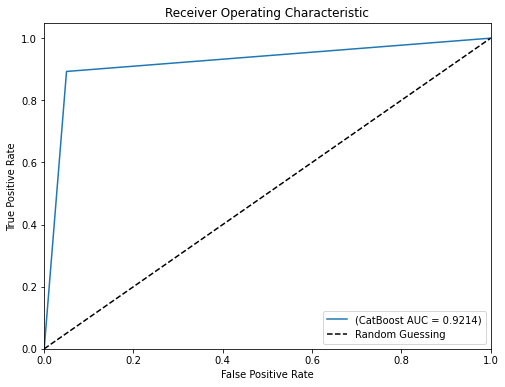

Value counts for y:
0    60
1    56
Name: fake, dtype: int64


Value counts for y_pred:
0    63
1    53
dtype: int64




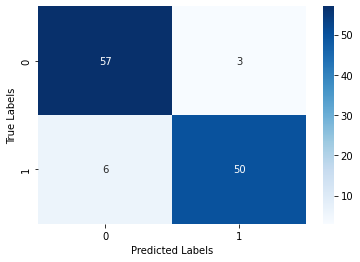



Recall Score: 89.0%


In [63]:
# Computing AUC-ROC score
auc = roc_auc_score(y, y_pred)
print(f"CatBoos: AUC-ROC score on unseen data = {auc:.4f}")

# Plotting ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, catboost_pipeline.predict(X))
plt.plot(fpr, tpr, label=f"(CatBoost AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Printing value counts
print("Value counts for y:")
print(y.value_counts())
print('\n')
print("Value counts for y_pred:")
print(pd.Series(y_pred).value_counts())
print('\n')
# Plotting confusion matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
print('\n')
print(f'Recall Score: {np.round(recall_score(y, y_pred),2) * 100}%') # Printing Recall Score

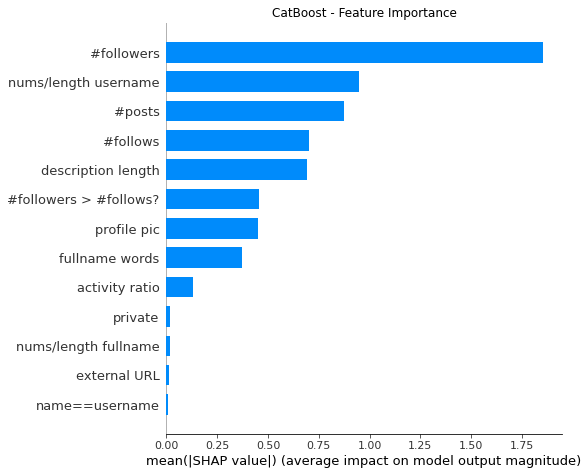

In [65]:
# Extracting the model and explainer
model = catboost_pipeline.named_steps['model']
explainer = shap.TreeExplainer(model)

# Computing the SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('CatBoost - Feature Importance')
plt.tight_layout()
plt.show()